In [2]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 87.9 MB/s eta 0:00:00


In [6]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt


In [4]:
import numpy as np
data = pd.read_csv('result_597.txt', sep=',', header=None, names=['state', 'year', 'score', 'number'])
# Filter out data points with 'number' less than 50
data = data[data['number'] >= 50]

data['panic_level'] = np.log(data['score'] / data['number'] +1)
data['new_score'] = data['panic_level'] 

In [12]:
#Calculate the global minimum and maximum panic levels:
min_panic_level = data['new_score'].min()
max_panic_level = data['new_score'].max()
avg_panic_level = data['new_score'].mean()
print(avg_panic_level)
min_new_score, max_new_score = min_panic_level, max_panic_level

print(min_new_score, max_new_score )

0.3447897902720991
-0.147527693622174 0.5888761058286769


In [20]:
connecticut_data = data[data['state'] == 'Connecticut']
new_york_data = data[data['state'] == 'New York']


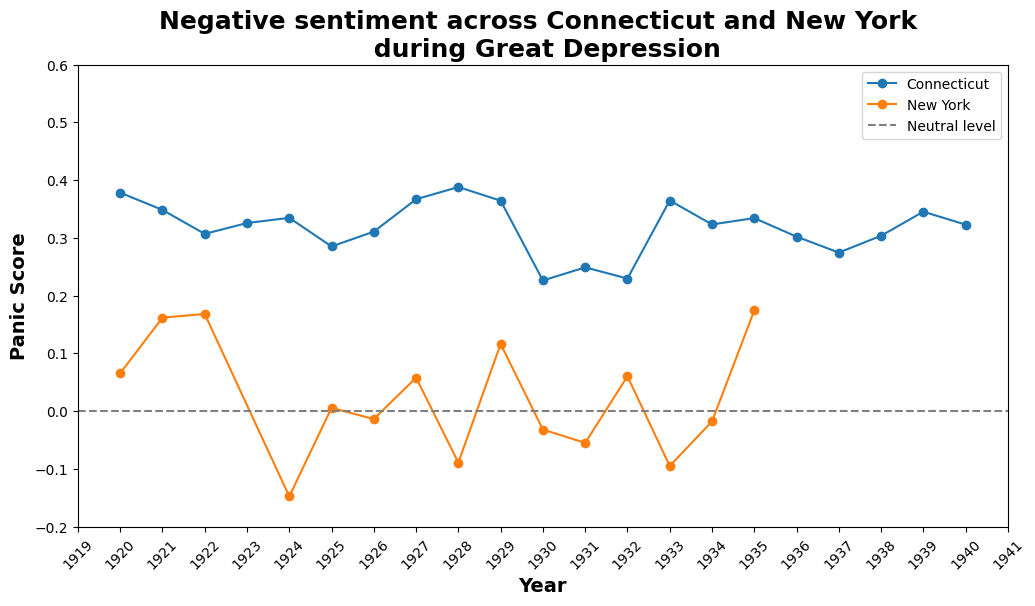

In [36]:
plt.figure(figsize=(12, 6))

plt.plot(connecticut_data ['year'], connecticut_data ['panic_level'], label='Connecticut', marker='o')
plt.plot(new_york_data['year'], new_york_data['panic_level'], label='New York', marker='o')

# Draw a dashed line at the average panic level
plt.axhline(y=0, color='gray', linestyle='--', label=f'Neutral level')

plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('Panic Score', fontsize=14, fontweight='bold')
plt.title('Negative sentiment across Connecticut and New York \n during Great Depression', fontsize=18, fontweight='bold')

plt.ylim([-0.2,0.6])
# Show the years as integers
plt.xticks(data['year'].unique(), rotation=45)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))

plt.legend()
plt.savefig('Comparison.png')
plt.show()


In [37]:
shapefile_path = '/content/ne_50m_admin_1_states_provinces.shp'
usa_map = gpd.read_file(shapefile_path)

# Filter the map to keep only the United States
usa_map = usa_map[usa_map['admin'] == 'United States of America']


In [38]:
import matplotlib.colors as mcolors


In [39]:
def normalize(value, min_value, max_value):
    return (value - min_value) / (max_value - min_value)


def create_custom_colormap(min_value, max_value, ave_value):
    colormap = mcolors.LinearSegmentedColormap.from_list(
        'custom_colormap',
        [
            (normalize(min_value, min_value, max_value), 'red'),
            (normalize(0.15, min_value, max_value), 'white'),
            (normalize(max_value, min_value, max_value), 'blue')
        ]
    )
    return colormap


In [40]:

def create_heatmap(year, data, usa_map, output_folder, vmin, vmax, colormap):
    data_year = data[data['year'] == year]
    merged_map = usa_map.set_index('name').join(data_year.set_index('state'))
    merged_map = merged_map.reset_index()

    fig, ax = plt.subplots(1, figsize=(20, 12))
    
    # Set a constant aspect ratio for the Axes object
    ax.set_aspect('equal', 'box')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    merged_map.plot(column='new_score', cmap=colormap, linewidth=0.8, ax=ax, edgecolor='0.8',
                    legend=True, cax=cax, vmin=vmin, vmax=vmax)

    ax.set_title(f"Heatmap of Panic Spread Across America's States ({year})", fontsize=20)
    ax.set_axis_off()

    plt.savefig(f"{output_folder}/heatmap_{year}.png", dpi=300)
    plt.close()


In [41]:
import os
output_folder = "heatmaps"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

unique_years = sorted(data['year'].unique())

colormap = create_custom_colormap(min_new_score, max_new_score, avg_panic_level)


for year in unique_years:
    create_heatmap(year, data, usa_map, output_folder, min_new_score, max_new_score, colormap)



In [ ]:
import cv2
import os

video_name = 'heatmap_evolution.mp4'
frame_rate = 1  # Set the number of frames per second

# Get the dimensions of the first image
first_image = cv2.imread(f"{output_folder}/heatmap_{unique_years[0]}.png")
height, width, _ = first_image.shape

# Set up the video writer with the mp4 codec
video_writer = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), frame_rate, (width, height))

# Add each image to the video
for year in unique_years:
    image = cv2.imread(f"{output_folder}/heatmap_{year}.png")
    video_writer.write(image)

# Release the video writer
video_writer.release()

